In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler

sns.set_theme(style="darkgrid")
sns.set(font_scale = 1.8)
colors = sns.color_palette("colorblind")

In [2]:
modality = 'music'

embedding_dimensions = {
    'video': 'placeholder',
    'music': 256,
}

## Load ground truth

In [3]:
groundtruth_df = pd.read_csv("groundtruth.csv")
groundtruth_df.set_index("stimulus_id", inplace=True)

In [4]:
merge_cases = [
    {
        "merged_name": "Outdoor and Sports",
        "cases_to_merge": ["Outdoor and Sports", "Ride-Ons, Bikes, Scooters and Skateboards"]
    },
    {
        "merged_name": "None of the Above",
        "cases_to_merge": ["None of the Above", "Video Gaming"]
    },
    {
        "merged_name": "Toy Vehicles, Building and Construction",
        "cases_to_merge": ["Toy Vehicles (Powered and Non-Powered)", "Building and Construction"]
    }
]

for merging_dict in merge_cases:
    for case in merging_dict["cases_to_merge"]:
        groundtruth_df.loc[groundtruth_df.product_category==case, "product_category"] = merging_dict["merged_name"]

groundtruth_df.head()

,product_category,filming_location,all_genders,interaction,voice_type,voice_age,voice_gender,voice_exagg,asian,black,...,description,upload_date,duration,view_count,categories,tags,like_count,requested_subtitles,download,error_logs
stimulus_id,,,,,,,,,,,,,,,,,,,,,
ndzo2ZIWfiQ,High-tech Interactive Playmates and Robotics,Non-specific,Girls/women,They do not interact with each other or there ...,BOTH spoken and sung,Adults (including young adults),Feminine,"No, all voices are normal-sounding",No,No,...,NaN,20120907,20,3047,['Autos & Vehicles'],['122975'],5,"{'en': {'ext': 'vtt', 'url': 'https://www.yout...",True,NaN
yRUiwRKk6QM,High-tech Interactive Playmates and Robotics,Indoors,Mixed,They do not interact with each other or there ...,Spoken,Adults (including young adults),Masculine,Yes a masculine voice is gender exaggerated,No,Yes,...,Now you can train like a Jedi! Use the power o...,20170920,34,25861,['Entertainment'],"['Smyths Toys', 'Toys', '(Industry)kids', 'Sta...",46,NaN,True,NaN
3ysC1-foJT4,"Apparel, Fashion, Accessories, Cosmetics, Cost...",Indoors,Girls/women,They are working or playing together in a coop...,Sung,Adults (including young adults),Feminine,Yes a feminine voice is gender exaggerated,No,No,...,Just add water to make endless crystal creatio...,20180802,30,2545,['Entertainment'],"['Smyths Toys', 'Toys (Industry)', 'kids', 'sm...",19,NaN,True,NaN
cYszuGaptkk,"Action Figures, Battling Toys and Toy Weapons",Non-specific,Mixed,They are working or playing together in a coop...,Spoken,Adults (including young adults),Feminine,"No, all voices are normal-sounding",No,Yes,...,Create your own exciting dino rescue missions ...,20201028,21,2035695,['Entertainment'],"['Smyths Toys', 'Toys (Industry)', 'kids', 'sm...",51,"{'en': {'ext': 'vtt', 'url': 'https://www.yout...",True,NaN
2LZjLBipdfI,Dolls,Indoors,Girls/women,They do not interact with each other or there ...,BOTH spoken and sung,Adults (including young adults),Feminine,Yes a feminine voice is gender exaggerated,No,No,...,Fabio & Fabia's Hair salon is the most loved p...,20201106,15,1834,['Entertainment'],"['Smyths Toys', 'Toys (Industry)', 'kids', 'sm...",10,NaN,True,NaN


In [5]:
not_found = 0
for stimulus_id in groundtruth_df.index:
    if os.path.exists(f"music/embeddings/{stimulus_id}_frontend.npy"):
        continue
    else:
        print(f"Embedding for {stimulus_id} not found")
        not_found += 1

assert not_found == 0

## Load embeddings

In [6]:
embedding_dim = embedding_dimensions[modality]

all_embeddings = np.empty((groundtruth_df.shape[0], embedding_dim))

for i,stimulus_id in enumerate(groundtruth_df.index):
    
    if modality == 'music':
        fn_suffix = '_backend'
    elif modality == 'video':
        fn_suffix = ''

    embedding = np.load(f"{modality}/embeddings/{stimulus_id}{fn_suffix}.npy")
    all_embeddings[i] = embedding.mean(axis=0)

all_embeddings.shape

(606, 256)

In [7]:
reducer = umap.UMAP(n_neighbors=20, random_state=42)
embeddings = StandardScaler().fit_transform(all_embeddings)
embeddings = reducer.fit_transform(embeddings)

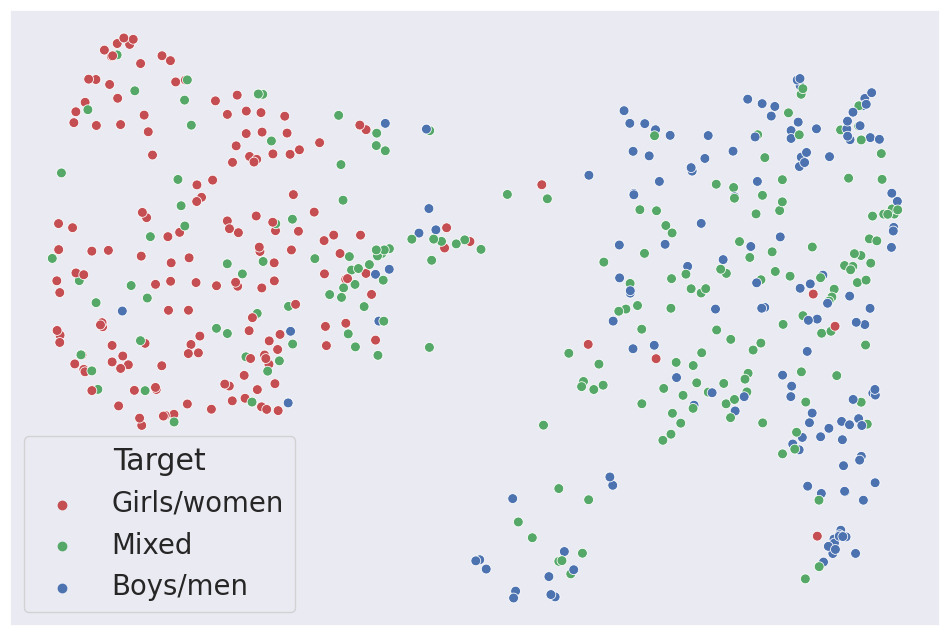

In [8]:
palette = {'Mixed':'C2','Girls/women':'C3','Boys/men':'C0','No actors':'C1'}

mask = groundtruth_df.all_genders.isin(["Girls/women", "Mixed", "Boys/men"])

plt.figure(figsize=(12,8))
g = sns.scatterplot(
        x= embeddings[mask,0], # type: ignore
        y= embeddings[mask,1], # type: ignore
        hue= groundtruth_df.loc[mask, "all_genders"],
        palette= palette, s=50
    )
g.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
g.grid(False)
g.legend(title="Target")
plt.show()
